<a href="https://colab.research.google.com/github/irfanshahmayeen/GR-08-CSE-445-Machine-Learnling-Stop-Sign-Detection-In-The-Street-/blob/Alamin/CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries


In [3]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
!pip install catboost
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


## Image Conversion

In [ ]:
# For Stop sign images
source_folder = "/content/drive/MyDrive/CSE 445 project/Project/Stop sign"
destination_folder = "/content/drive/MyDrive/CSE 445 project/Dataset/Stop sign"

# Create destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Get all PNG files from the source folder
png_files = [f for f in os.listdir(source_folder) if f.lower().endswith(".png")]

# Sort files to maintain order
png_files.sort()

# Convert and rename PNG files
for index, file in enumerate(png_files, start=1):
    img_path = os.path.join(source_folder, file)
    img = Image.open(img_path)
    rgb_img = img.convert("RGB")  # Convert to RGB mode

    new_filename = f"{index}.jpg"
    save_path = os.path.join(destination_folder, new_filename)

    rgb_img.save(save_path, "JPEG")
    print(f"Saved: {save_path}")

print("Stop sign conversion complete!")

Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/1.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/2.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/3.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/4.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/5.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/6.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/7.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/8.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/9.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/10.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/11.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/12.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/13.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Stop sign/14.jpg
Saved: /content

In [ ]:
# For Non-stop sign images
source_folder = "/content/drive/MyDrive/CSE 445 project/Project/Non stop sign"
destination_folder = "/content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign"

# Create destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Get all PNG files from the source folder
png_files = [f for f in os.listdir(source_folder) if f.lower().endswith(".png")]

# Sort files to maintain order
png_files.sort()

# Convert and rename PNG files
for index, file in enumerate(png_files, start=1):
    img_path = os.path.join(source_folder, file)
    img = Image.open(img_path)
    rgb_img = img.convert("RGB")

    new_filename = f"{index}.jpg"
    save_path = os.path.join(destination_folder, new_filename)

    rgb_img.save(save_path, "JPEG")
    print(f"Saved: {save_path}")

print("Non stop sign conversion complete!")

Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/1.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/2.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/3.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/4.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/5.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/6.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/7.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/8.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/9.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/10.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/11.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/12.jpg
Saved: /content/drive/MyDrive/CSE 445 project/Dataset/Non stop sign/13.jpg
Saved: /content/drive/MyDrive/CSE 

## Data Loading, Preprocessing and Augmentation

Number of Non stop sign images: 50
Number of Stop sign images: 50
Class distribution: Non stop sign: 50, Stop sign: 50
Augmented dataset shape: (900, 64, 64, 3)
Augmented class distribution: Non stop sign: 450, Stop sign: 450


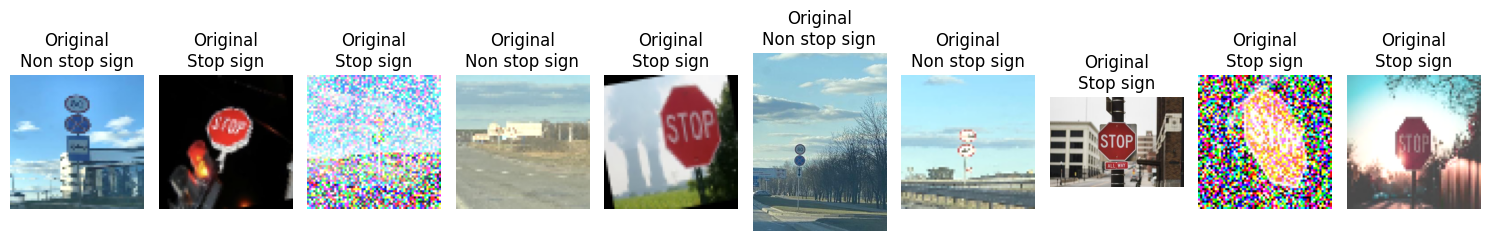

In [4]:
dataset_path = "/content/drive/MyDrive/CSE 445 project/Dataset"
categories = ["Non stop sign", "Stop sign"]
IMG_SIZE = 64

data = []
labels = []
original_images = []

# Load images for each category
for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    image_files = os.listdir(folder_path)
    print(f"Number of {category} images: {len(image_files)}")
    for filename in image_files:
        img_path = os.path.join(folder_path, filename)
        img_original = cv2.imread(img_path)
        if img_original is None:
            continue
        original_images.append(img_original)
        img = cv2.resize(img_original, (IMG_SIZE, IMG_SIZE))
        data.append(img)
        labels.append(label)

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Check class distribution
print(f"Class distribution: Non stop sign: {np.sum(labels == 0)}, Stop sign: {np.sum(labels == 1)}")

# Balance the dataset by undersampling
min_samples = min(np.sum(labels == 0), np.sum(labels == 1))
balanced_data = []
balanced_labels = []
balanced_originals = []

for label in [0, 1]:
    indices = np.where(labels == label)[0]
    np.random.shuffle(indices)
    selected_indices = indices[:min_samples]
    balanced_data.extend(data[selected_indices])
    balanced_labels.extend(labels[selected_indices])
    balanced_originals.extend([original_images[i] for i in selected_indices])

# Enhanced data augmentation with more variations
augmented_data = []
augmented_labels = []
augmented_originals = []

for img, label, orig_img in zip(balanced_data, balanced_labels, balanced_originals):
    # Original image
    augmented_data.append(img)
    augmented_labels.append(label)
    augmented_originals.append(orig_img)

    # Rotate +10 degrees
    M = cv2.getRotationMatrix2D((IMG_SIZE/2, IMG_SIZE/2), 10, 1)
    rotated = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE))
    augmented_data.append(rotated)
    augmented_labels.append(label)
    augmented_originals.append(rotated)

    # Rotate -10 degrees
    M = cv2.getRotationMatrix2D((IMG_SIZE/2, IMG_SIZE/2), -10, 1)
    rotated = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE))
    augmented_data.append(rotated)
    augmented_labels.append(label)
    augmented_originals.append(rotated)

    # Brightness increase
    bright = cv2.convertScaleAbs(img, beta=30)
    augmented_data.append(bright)
    augmented_labels.append(label)
    augmented_originals.append(bright)

    # Brightness decrease
    dark = cv2.convertScaleAbs(img, beta=-30)
    augmented_data.append(dark)
    augmented_labels.append(label)
    augmented_originals.append(dark)

    # Horizontal flip
    flipped = cv2.flip(img, 1)
    augmented_data.append(flipped)
    augmented_labels.append(label)
    augmented_originals.append(flipped)

    # Contrast adjustment (increase)
    contrast_up = cv2.convertScaleAbs(img, alpha=1.3, beta=0)
    augmented_data.append(contrast_up)
    augmented_labels.append(label)
    augmented_originals.append(contrast_up)

    # Contrast adjustment (decrease)
    contrast_down = cv2.convertScaleAbs(img, alpha=0.7, beta=0)
    augmented_data.append(contrast_down)
    augmented_labels.append(label)
    augmented_originals.append(contrast_down)

    # Add Gaussian noise
    noise = np.random.normal(0, 15, img.shape).astype(np.uint8)
    noisy_img = cv2.add(img, noise)
    augmented_data.append(noisy_img)
    augmented_labels.append(label)
    augmented_originals.append(noisy_img)

# Convert to numpy arrays
data = np.array(augmented_data)
labels = np.array(augmented_labels)
original_images = augmented_originals

print(f"Augmented dataset shape: {data.shape}")
print(f"Augmented class distribution: Non stop sign: {np.sum(labels == 0)}, Stop sign: {np.sum(labels == 1)}")

# Visualize augmented images
num_images = 10
random_indices = np.random.choice(len(original_images), num_images, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images, i + 1)
    original_rgb = cv2.cvtColor(original_images[idx], cv2.COLOR_BGR2RGB)
    plt.imshow(original_rgb)
    plt.title(f"Original\n{categories[labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Feature Extraction

In [ ]:
def extract_shape_features(img):
    # Convert to HSV for color-based masking
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Define red color range for stop signs
    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = mask1 | mask2
    # Apply mask to isolate red regions
    red_only = cv2.bitwise_and(img, img, mask=red_mask)
    gray = cv2.cvtColor(red_only, cv2.COLOR_BGR2GRAY)
    # Threshold to binarize
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    # Find contours on the masked image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)
    largest_area = 0
    num_sides = 0
    is_circular = 0
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        largest_area = cv2.contourArea(largest_contour)
        approx = cv2.approxPolyDP(largest_contour, 0.01 * cv2.arcLength(largest_contour, True), True)
        num_sides = len(approx)
        perimeter = cv2.arcLength(largest_contour, True)
        area = cv2.contourArea(largest_contour)
        if perimeter > 0:
            circularity = 4 * np.pi * area / (perimeter * perimeter)
            is_circular = 1 if circularity > 0.8 else 0
    return np.array([num_contours, largest_area / (IMG_SIZE * IMG_SIZE), num_sides, is_circular])

features = []
for img in data:
    # HOG features
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray_float = img_gray / 255.0
    hog_feat = hog(img_gray_float,
                   pixels_per_cell=(6, 6),
                   cells_per_block=(2, 2),
                   orientations=9,
                   feature_vector=True)

    # Enhanced color features
    red_channel = img[:, :, 2]
    red_hist = np.histogram(red_channel, bins=64, range=(0, 256))[0]  # More bins for finer detail
    red_hist = red_hist / (red_hist.sum() + 1e-10)
    red_mean = np.mean(red_channel) / 255.0  # Normalized mean red intensity

    green_channel = img[:, :, 1]
    green_hist = np.histogram(green_channel, bins=32, range=(0, 256))[0]
    green_hist = green_hist / (green_hist.sum() + 1e-10)

    blue_channel = img[:, :, 0]
    blue_hist = np.histogram(blue_channel, bins=32, range=(0, 256))[0]
    blue_hist = blue_hist / (blue_hist.sum() + 1e-10)

    # LBP texture features
    img_gray_uint8 = img_gray.astype(np.uint8)
    lbp = local_binary_pattern(img_gray_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=26, range=(0, 26), density=True)

    # Shape features with red masking
    shape_feat = extract_shape_features(img)

    # Edge density
    edges = cv2.Canny(img_gray_uint8, 100, 200)
    edge_density = np.sum(edges > 0) / (IMG_SIZE * IMG_SIZE)

    # Combine all features
    combined_features = np.concatenate([hog_feat, red_hist, green_hist, blue_hist, lbp_hist, shape_feat, [edge_density, red_mean]])
    features.append(combined_features)

# Convert to numpy array
X_features = np.array(features)
print("Feature extraction completed. Shape:", X_features.shape)

# Feature scaling
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

# Dimensionality reduction with PCA
pca = PCA(n_components=100, random_state=42)
X_features_reduced = pca.fit_transform(X_features_scaled)
print("PCA reduced feature shape:", X_features_reduced.shape)
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")

Feature extraction completed. Shape: (1008, 3076)
PCA reduced feature shape: (1008, 100)
Explained variance ratio: 0.6888


## Train-Test Split

Training samples: 806, Testing samples: 202
Training set label distribution: [403 403] (0: Non stop, 1: Stop)
Testing set label distribution: [101 101] (0: Non stop, 1: Stop)


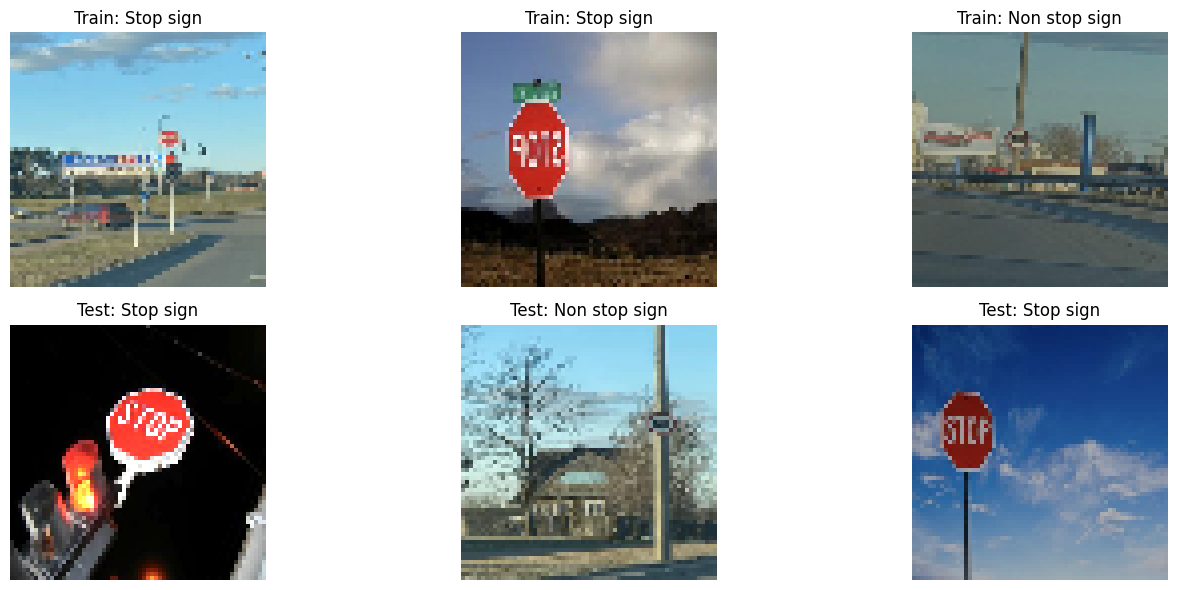

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_features_reduced, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print(f"Training set label distribution: {np.bincount(y_train)} (0: Non stop, 1: Stop)")
print(f"Testing set label distribution: {np.bincount(y_test)} (0: Non stop, 1: Stop)")

# Visualize train and test samples
num_samples = 3
train_indices = np.random.choice(len(X_train), num_samples, replace=False)
test_indices = np.random.choice(len(X_test), num_samples, replace=False)
X_full_indices = np.arange(len(X_features))
X_train_indices, X_test_indices = train_test_split(
    X_full_indices, test_size=0.2, random_state=42, stratify=labels
)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(train_indices):
    orig_idx = X_train_indices[idx]
    plt.subplot(2, num_samples, i + 1)
    original_rgb = cv2.cvtColor(original_images[orig_idx], cv2.COLOR_BGR2RGB)
    plt.imshow(original_rgb)
    plt.title(f"Train: {categories[y_train[idx]]}")
    plt.axis('off')

for i, idx in enumerate(test_indices):
    orig_idx = X_test_indices[idx]
    plt.subplot(2, num_samples, i + num_samples + 1)
    original_rgb = cv2.cvtColor(original_images[orig_idx], cv2.COLOR_BGR2RGB)
    plt.imshow(original_rgb)
    plt.title(f"Test: {categories[y_test[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Train CatBoost Model

Cross-validation accuracy: 0.9193 ± 0.0132
0:	learn: 0.7960298	total: 8.93ms	remaining: 4.46s
100:	learn: 0.9771712	total: 936ms	remaining: 3.69s
200:	learn: 1.0000000	total: 1.81s	remaining: 2.69s
300:	learn: 1.0000000	total: 2.69s	remaining: 1.77s
400:	learn: 1.0000000	total: 3.57s	remaining: 881ms
499:	learn: 1.0000000	total: 4.46s	remaining: 0us

CatBoost Model Accuracy: 0.9356435643564357

Classification Report:
               precision    recall  f1-score   support

Non stop sign       0.92      0.96      0.94       101
    Stop sign       0.96      0.91      0.93       101

     accuracy                           0.94       202
    macro avg       0.94      0.94      0.94       202
 weighted avg       0.94      0.94      0.94       202


Confusion Matrix:
[[97  4]
 [ 9 92]]


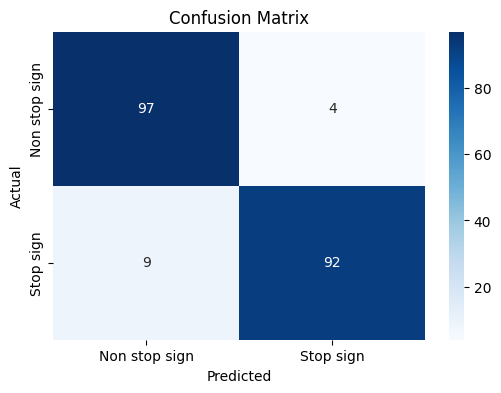

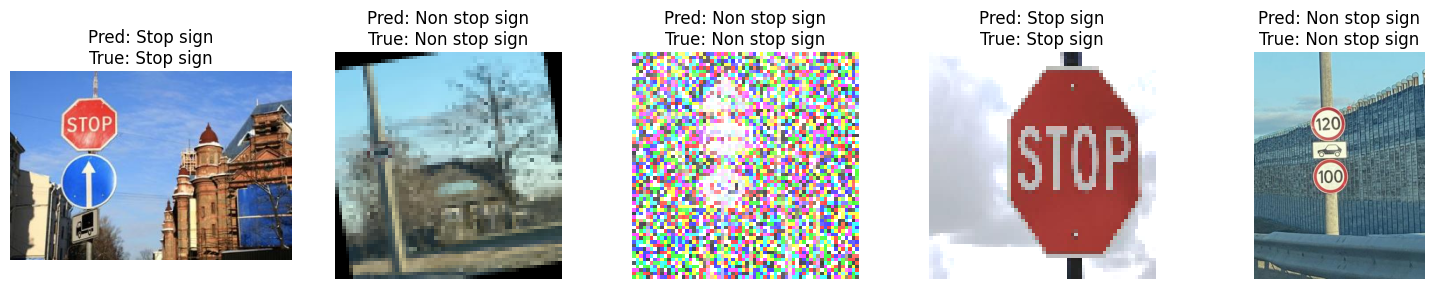

In [ ]:
catboost_model = CatBoostClassifier(
    iterations=500,
    depth=4,
    learning_rate=0.05,
    random_seed=42,
    verbose=100,
    class_weights=[1.0, 1.5],  # Slight weight to Stop sign
    eval_metric='Accuracy'
)

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    catboost_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)
    y_val_pred = catboost_model.predict(X_val)
    cv_scores.append(accuracy_score(y_val, y_val_pred))
print(f"Cross-validation accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Train on full training data
catboost_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = catboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nCatBoost Model Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize predictions
num_samples = 5
test_indices = np.random.choice(len(X_test), num_samples, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(test_indices):
    orig_idx = X_test_indices[idx]
    plt.subplot(1, num_samples, i + 1)
    original_rgb = cv2.cvtColor(original_images[orig_idx], cv2.COLOR_BGR2RGB)
    plt.imshow(original_rgb)
    pred_label = categories[y_pred[idx]]
    true_label = categories[y_test[idx]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    if pred_label != true_label:
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Prediction Result


Testing image: /content/drive/MyDrive/CSE 445 project/Test images/Stop sign/10.jpg


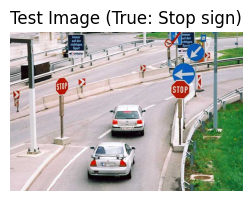

Prediction: Stop sign
Confidence scores: Non stop sign: 0.08, Stop sign: 0.92
Final Prediction: Stop sign

Testing image: /content/drive/MyDrive/CSE 445 project/Test images/Non stop sign/road135.png


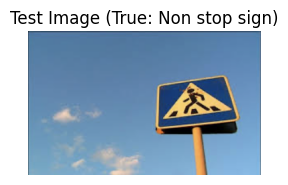

Prediction: Non stop sign
Confidence scores: Non stop sign: 0.82, Stop sign: 0.18
Final Prediction: Non stop sign


In [ ]:
def predict_stop_sign(image_path, true_label):
    # Load the test image
    if image_path.lower().endswith('.png'):
        img = Image.open(image_path).convert('RGB')
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    else:
        img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return None

    # Display the test image
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Test Image (True: {true_label})")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Extract features
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray_float = img_gray / 255.0
    hog_feat = hog(img_gray_float,
                   pixels_per_cell=(6, 6),
                   cells_per_block=(2, 2),
                   orientations=9,
                   feature_vector=True)

    red_channel = img[:, :, 2]
    red_hist = np.histogram(red_channel, bins=64, range=(0, 256))[0]
    red_hist = red_hist / (red_hist.sum() + 1e-10)
    red_mean = np.mean(red_channel) / 255.0

    green_channel = img[:, :, 1]
    green_hist = np.histogram(green_channel, bins=32, range=(0, 256))[0]
    green_hist = green_hist / (green_hist.sum() + 1e-10)

    blue_channel = img[:, :, 0]
    blue_hist = np.histogram(blue_channel, bins=32, range=(0, 256))[0]
    blue_hist = blue_hist / (blue_hist.sum() + 1e-10)

    img_gray_uint8 = img_gray.astype(np.uint8)
    lbp = local_binary_pattern(img_gray_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=26, range=(0, 26), density=True)

    shape_feat = extract_shape_features(img)

    edges = cv2.Canny(img_gray_uint8, 100, 200)
    edge_density = np.sum(edges > 0) / (IMG_SIZE * IMG_SIZE)

    img_features = np.concatenate([hog_feat, red_hist, green_hist, blue_hist, lbp_hist, shape_feat, [edge_density, red_mean]])

    # Scale and reduce features
    img_features_scaled = scaler.transform([img_features])
    img_features_reduced = pca.transform(img_features_scaled)

    # Predict with custom threshold
    probabilities = catboost_model.predict_proba(img_features_reduced)[0]
    stop_sign_threshold = 0.3  # Lower threshold for stop sign to reduce false negatives
    prediction = 1 if probabilities[1] >= stop_sign_threshold else 0

    print(f"Prediction: {categories[prediction]}")
    print(f"Confidence scores: Non stop sign: {probabilities[0]:.2f}, Stop sign: {probabilities[1]:.2f}")

    return categories[prediction]

# Test with multiple images
test_images = [
    ("/content/drive/MyDrive/CSE 445 project/Test images/Stop sign/10.jpg", "Stop sign"),
    ("/content/drive/MyDrive/CSE 445 project/Test images/Non stop sign/road135.png", "Non stop sign")
]
for test_image, true_label in test_images:
    print(f"\nTesting image: {test_image}")
    result = predict_stop_sign(test_image, true_label)
    if result:
        print("Final Prediction:", result)